In [3]:
import pandas as pd
df = pd.read_csv("../model summary/california_housing.csv")
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          20640 non-null  int64  
 1   longitude           20640 non-null  float64
 2   latitude            20640 non-null  float64
 3   housing_median_age  20640 non-null  float64
 4   total_rooms         20640 non-null  float64
 5   total_bedrooms      20433 non-null  float64
 6   population          20640 non-null  float64
 7   households          20640 non-null  float64
 8   median_income       20640 non-null  float64
 9   median_house_value  20640 non-null  float64
 10  ocean_proximity     20640 non-null  object 
dtypes: float64(9), int64(1), object(1)
memory usage: 1.7+ MB


,Unnamed: 0,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,10319.500000,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,5958.399114,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,0.000000,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,5159.750000,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,10319.500000,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,15479.250000,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,20639.000000,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


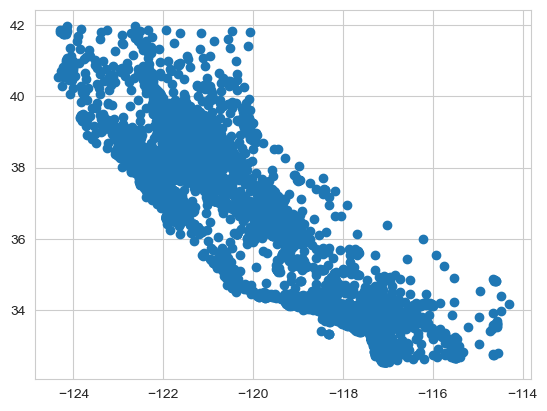

In [11]:
from matplotlib import pyplot as plt
plt.scatter(df.longitude,df.latitude)